In [1]:
import gausspy

In [2]:
# Read fits datacube and save in GaussPy format
import numpy as np
import pickle
import auxiliary_functions as aux
import FigureMove as Fig
import os.path
import matplotlib.pyplot as plt 
import matplotlib as mpl
import scipy
# from astropy.io import fits

# Specify necessary parameters
# FILENAME_DATA = 'M33only.fits'
# FILENAME_DATA_GAUSSPY = 'cube.pickle'

# hdu_list = fits.open(FILENAME_DATA)
# hdu = hdu_list[0]
# cube = hdu.data

grouping = 4
resolution = 192
resolutionDepth = 400
height = 0.092
width = 0.092
elementsI = round(height/max([height,width])*resolution/grouping)
elementsJ = round(width/max([height,width])*resolution/grouping)

folder = '/home/kristian/Analysis/analyzeScripts/figures/Histogram/PerseusCorrect-R7-E45-X5M1ASFCMy15Ver2020Up10p3p2020/RotE2x010_Rot0100_VelocityBelowXkeVY_ThreshVelKeV20MassPassiveScalar/Group4/ResFit15/all/'
folder = '/home/kristian/analysis/figures/Histogram/home-kristian-analysis-TestSim/RotE2x010_Rot0100_VelocityBelowXkeVY_ThreshVelKeV20MassPassiveScalar/Group4/ResFit15/all/'
fileBeg = 'GausWeighdataweightsRotE2x010_Rot0100_VelocityBelowXkeVY_ThreshVelKeV20MassPassiveScalar_PerseusCorrect-R7-E45-X5M1ASFCMy15Ver2020Up10p3p2020_R192-400-192_G4_'
fileBeg = 'GausWeighdataweightsRotE2x010_Rot0100_VelocityBelowXkeVY_ThreshVelKeV20MassPassiveScalar_home-kristian-analysis-TestSim_R192-400-192_G4_'
fileEnd = '.npy'

def getFileName(i,j):
    file = Fig.findAllFilesWithBeginning(folder, fileBeg+'%i_%i_'%(i,j))
    file = [x for x in file if fileEnd in x]
    if len(file)>1:
        print(fileBeg+'%i_%i'%(i,j))
        print([os.path.split(x)[-1] for x in file])
        print('more than 1 file matches!')
        return file[0]
    elif len(file)>0:
        return file[0]
    else:
        return None

couldnt import gadget!
[100, 150] [0.5, 0.5, 0.5] [1.0, 1.0, 1.0]
arepo not imprted


In [3]:
data = {}

FILENAME_DATA_GAUSSPY = 'cube.pickle'

# cycle through each spectrum
binsize = 15
velocityRange = [-1000,1000]
#make sure velocityRange divisible by binsize
velocityRange[1] += 15-np.sum(np.abs(velocityRange))%binsize
Nbins =  int(np.sum(np.abs(velocityRange))/binsize)

RMS = 5e-4
SNR = 5
errors = np.ones(Nbins) * RMS
chan = np.arange(Nbins)


print('Nbins {}'.format(Nbins))
print('velocityRange: {}'.format(velocityRange))
MAX = velocityRange[1]
MIN = velocityRange[0]
nFiles = 0
elementsData = []
for i in range(elementsI):
    for j in range(elementsJ):

        filename = getFileName(i,j)
        if filename is not None:
#             print(j+i*elementsI)
            nFiles += 1
            velos, weights = np.load(filename)
            if np.max(velos[0])>MAX:
                print('velocity exceeds range: {} vs {}'.format(MAX, np.max(velos[0])))
            if np.min(velos[0])<MIN:
                print('velocity below range: {} vs {}'.format(MIN, np.min(velos[0])))
            bins = np.arange(velocityRange[0], velocityRange[1]+binsize, binsize)
            hist, bin_edges, binnumber = scipy.stats.binned_statistic(velos, weights, 'sum', bins)
            hist = hist/np.sum(hist)/np.diff(bin_edges)[0]
#             print('mean: {}, median: {}, max: {}, min: {}'.format(np.mean(hist),np.median(hist),np.max(hist),np.min(hist)))
            errors = np.ones(Nbins)*RMS
            elementsData.append(j+i*elementsI)
        else:
            hist = np.full(Nbins, np.nan)
            errors = np.full(Nbins, np.nan)
        # get the spectrum
        spectrum = hist

        # get the spectrum location
        location = np.array((i, j))

        # Enter results into GaussPy-friendly dataset
        data['data_list'] = data.get('data_list', []) + [spectrum]
        data['x_values'] = data.get('x_values', []) + [chan]
        data['errors'] = data.get('errors', []) + [errors]
        data['location'] = data.get('location', []) + [location]
print('found %i files' %nFiles)
# Save decomposition information
# pickle.dump(data, open(FILENAME_DATA_GAUSSPY, 'w'))
pickle.dump(data, open(FILENAME_DATA_GAUSSPY, 'wb'))
print('.. saved %s'%FILENAME_DATA_GAUSSPY)
# [r"{}=> {} \n".format(k,v[1171]) for k,v in data.items()]

Nbins 134
velocityRange: [-1000, 1010]
found 92 files
.. saved cube.pickle


## Plots some exemplatory spectra

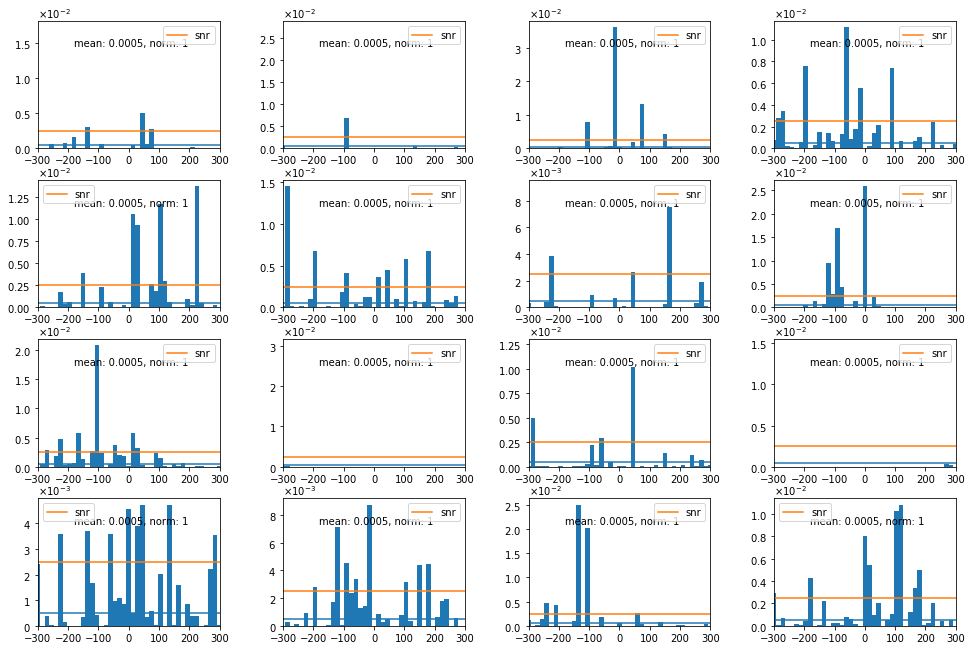

In [4]:
Nplots = 16

data = pickle.load(open(FILENAME_DATA_GAUSSPY, 'rb'))#, 'rb')

rng = np.random.default_rng()
choices = rng.choice(len(elementsData), size=Nplots, replace=False)

fig = plt.figure(figsize=(15,10))
for index, number in enumerate(np.array(elementsData)[choices]):
    ax = fig.add_subplot(4, 4, index+1)
    hist = data['data_list'][number]
    x = data['x_values'][number]*binsize-np.sum(np.abs(velocityRange))/2
    err = data['errors'][number]
    ax.bar(x, hist, width=np.diff(x)[0])
    ax.plot(x, err)
    ax.plot(x, err*SNR, label='snr')
    ax.set_xlim([-300,300])
    mf = mpl.ticker.ScalarFormatter(useMathText=True)
    mf.set_powerlimits((-2,2))
    ax.text(0.2,0.8,'mean: %.2g, norm: %.2g'%(np.mean(hist),np.sum(hist*np.diff(bin_edges))),transform=ax.transAxes)
    ax.yaxis.set_major_formatter(mf)
    ax.legend()
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)

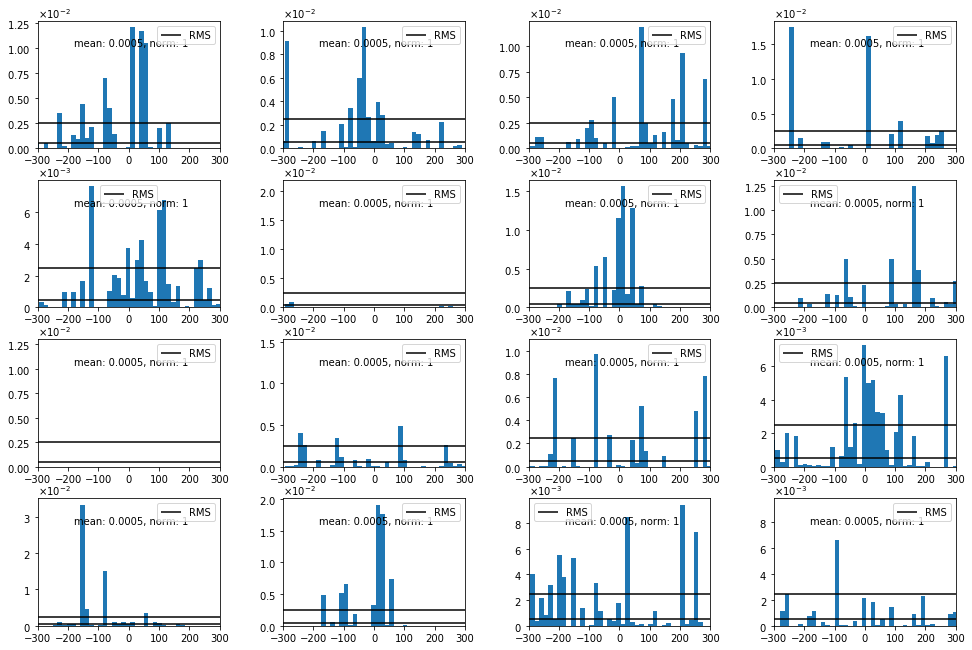

In [5]:
Nplots = 16

files = Fig.findAllFilesWithEnding(folder, '.npy')

rng = np.random.default_rng()
choices = rng.choice(len(files), size=Nplots, replace=False)

fig = plt.figure(figsize=(15,10))
for index, file in enumerate(np.array(files)[choices]):
    ax = fig.add_subplot(4, 4, index+1)
    velos, weights = np.load(file)
    hist, bin_edges, binnumber = scipy.stats.binned_statistic(velos, weights, 'sum', bins)
    hist = hist/np.sum(hist)/np.diff(bin_edges)
    ax.bar(bin_edges[:-1]+np.diff(bin_edges)/2, hist, width=np.diff(bin_edges)[0])
    ax.hlines(np.mean(hist),velocityRange[0],velocityRange[1])
    ax.hlines(np.mean(hist)*SNR,velocityRange[0],velocityRange[1], label='RMS')
    ax.set_xlim([-300,300])
    mf = mpl.ticker.ScalarFormatter(useMathText=True)
    mf.set_powerlimits((-2,2))
    ax.text(0.2,0.8,'mean: %.2g, norm: %.2g'%(np.mean(hist),np.sum(hist*np.diff(bin_edges))),transform=ax.transAxes)
    ax.yaxis.set_major_formatter(mf)
    ax.legend()
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)

## Creating synthetic training set fitting data

In [6]:
import numpy as np
import pickle

def gaussian(amp, fwhm, mean):
    return lambda x: amp * np.exp(-4. * np.log(2) * (x-mean)**2 / fwhm**2)

# Estimate of the root-mean-square uncertainty per channel (RMS)
RMS = 1e-3

# Specify the number of spectral channels (NCHANNELS)
NCHANNELS = Nbins

# Specify the number of spectra (NSPECTRA)
NSPECTRA = 50 #int(elementsI/2)*int(elementsJ/2)

# Estimate the number of components
NCOMPS_lims = [1,6]

# Specify the min-max range of possible properties of the Gaussian function paramters:
AMP_lims = [8e-3,1e-1]
FWHM_lims = [1,10] # channels
MEAN_lims = [int(Nbins*0.2),int(Nbins*0.8)] # channels

# Indicate whether the data created here will be used as a training set
# (a.k.a. decide to store the "true" answers or not at the end)
TRAINING_SET = True

# Specify the pickle file to store the results in
FILENAME_TRAIN = 'cube_training_data.pickle'

# Initialize
data = {}
chan = np.arange(NCHANNELS)
errors = np.ones(NCHANNELS) * RMS

# Begin populating data
for i in range(NSPECTRA):
    spectrum_i = np.random.randn(NCHANNELS) * RMS

    amps = []
    fwhms = []
    means = []

    ncomps = np.random.choice((np.arange(NCOMPS_lims[0],NCOMPS_lims[1]+1)))

    for comp in range(ncomps):
        # Select random values for components within specified ranges
        a = np.random.uniform(AMP_lims[0], AMP_lims[1])
        w = np.random.uniform(FWHM_lims[0], FWHM_lims[1])
        m = np.random.uniform(MEAN_lims[0], MEAN_lims[1])

        # Add Gaussian profile with the above random parameters to the spectrum
        spectrum_i += gaussian(a, w, m)(chan)

        # Append the parameters to initialized lists for storing
        amps.append(a)
        fwhms.append(w)
        means.append(m)

    # Enter results into AGD dataset
    data['data_list'] = data.get('data_list', []) + [spectrum_i]
    data['x_values'] = data.get('x_values', []) + [chan]
    data['errors'] = data.get('errors', []) + [errors]

    # If training data, keep answers
    if TRAINING_SET:
        data['amplitudes'] = data.get('amplitudes', []) + [amps]
        data['fwhms'] = data.get('fwhms', []) + [fwhms]
        data['means'] = data.get('means', []) + [means]

# Dump synthetic data into specified filename
pickle.dump(data, open(FILENAME_TRAIN, 'wb'))

## Visualize training set

In [7]:
Nplots = 16

data = pickle.load(open(FILENAME_TRAIN, 'rb'))#, 'rb')

rng = np.random.default_rng()
choices = rng.choice(NSPECTRA, size=Nplots, replace=False)

fig = plt.figure(figsize=(15,10))
for index, number in enumerate(choices):
    ax = fig.add_subplot(4, 4, index+1)
    hist = data['data_list'][number]
    x = data['x_values'][number]*binsize-np.sum(np.abs(velocityRange))/2
    err = data['errors'][number]
    ax.bar(x, hist, width=np.diff(x)[0])
    ax.plot(x, err)
    ax.plot(x, err*SNR)
    ax.set_xlim([-1000,1000])
    mf = mpl.ticker.ScalarFormatter(useMathText=True)
    mf.set_powerlimits((-2,2))
    ax.text(0.2,0.8,'mean: %.2g, norm: %.2g'%(np.mean(hist),np.sum(hist*np.diff(bin_edges))),transform=ax.transAxes)
    ax.yaxis.set_major_formatter(mf)
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)

## Training training set

In [8]:
# Train AGD using synthetic dataset
import numpy as np
import pickle
import gausspy.gp as gp
import importlib
importlib.reload(gp)

# Set necessary parameters
FILENAME_TRAIN = 'cube_training_data.pickle'
snr_thresh = SNR#*1e3
alpha1_initial = 1.0
alpha2_initial = 12

g = gp.GaussianDecomposer()

# Next, load the training dataset for analysis:
g.load_training_data(FILENAME_TRAIN)

# Set GaussPy parameters
g.set('phase', 'two')
g.set('SNR_thresh', [snr_thresh,snr_thresh])

# Train AGD starting with initial guess for alpha
# g.train(alpha1_initial = alpha1_initial, alpha2_initial = alpha2_initial, verbose=True)
g.train(alpha1_initial = alpha1_initial, alpha2_initial=alpha2_initial, verbose=True)

Training...

  --> AGD() 

  --> AGD() 




  --> initialGuess() 


  --> initialGuess() 


Algorithm parameters: 
Algorithm parameters: 
alpha = 17.78279410038923
alpha = 17.78279410038923

  --> AGD() 
SNR_thesh = 5
SNR2_thesh = 5.0
SNR_thesh = 5
BLFrac = 0.1


  --> AGD() 



  --> initialGuess() 

Algorithm parameters: 
SNR2_thesh = 5.0
BLFrac = 0.1
Taking python derivatives...


  --> initialGuess() 
Taking python derivatives...
alpha = 17.78279410038923

Algorithm parameters: 
alpha = 17.78279410038923
SNR_thesh = 5
SNR2_thesh = 5.0
BLFrac = 0.1
Taking python derivatives...
SNR_thesh = 5
SNR2_thesh = 5.0
BLFrac = 0.1
Taking python derivatives...
N CPUs:  4
...took 0.10 seconds per derivative.
Second derivative noise: 1.5932684873093776e-05
...took 0.11 seconds per derivative.
Second derivative threshold: -7.966342436546888e-05
...took 0.09 seconds per derivative.
Second derivative noise: 0.0001506958085963807
Components found for alpha=17.78279410038923: 1
Second derivative noise


Algorithm parameters: 
alpha = 1000000000000.0
SNR_thesh = 5
SNR2_thesh = 5.0
BLFrac = 0.1
Taking python derivatives...
...took 0.14 seconds per derivative.
Second derivative noise: 1.9289614802954386e-20
Second derivative threshold: -9.644807401477194e-20
Components found for alpha=1000000000000.0: 0

  --> AGD() 



  --> initialGuess() 

Algorithm parameters: 
alpha = 17.78279410038923
SNR_thesh = 5
SNR2_thesh = 5.0
BLFrac = 0.1
Taking python derivatives...
...took 0.18 seconds per derivative.
Second derivative noise: 6.960248829718998e-20
Second derivative threshold: -3.4801244148594986e-19
Components found for alpha=1000000000000.0: 0
...took 0.14 seconds per derivative.
Second derivative noise: 5.674655411462979e-21

  --> AGD() 
Second derivative threshold: -2.8373277057314897e-20
Components found for alpha=1000000000000.0: 0

  --> AGD() 



  --> initialGuess() 



  --> initialGuess() 


Algorithm parameters: 
Algorithm parameters: 
alpha = 17.78279410038923
SNR_thesh = 5
SN



  --> initialGuess() 

...took 0.14 seconds per derivative.
Second derivative noise: 1.7324494133393093e-05
Algorithm parameters: 
alpha = 1000000000000.0
SNR_thesh = 5
Second derivative threshold: -8.662247066696547e-05
Components found for alpha=17.78279410038923: 1
SNR2_thesh = 5.0
BLFrac = 0.1
Beginning phase-two AGD... 
Running LMFIT on initial narrow components...
Taking python derivatives...


  --> initialGuess() 

Algorithm parameters: 
alpha = 1000000000000.0
SNR_thesh = 5
SNR2_thesh = 5.0
BLFrac = 0.1
Taking python derivatives...
...took 0.10 seconds per derivative.
Second derivative noise: 2.6315417256823156e-05
Second derivative threshold: -0.00013157708628411577
Components found for alpha=17.78279410038923: 2
Beginning phase-two AGD... 
Running LMFIT on initial narrow components...


  --> initialGuess() 

...took 0.12 seconds per derivative.
Second derivative noise: 2.4199477478949448e-20
Second derivative threshold: -1.2099738739474724e-19
Algorithm parameters: 
Compo

...took 0.15 seconds per derivative.
Second derivative noise: 7.948961095867056e-21
Beginning phase-two AGD... 
Second derivative threshold: -3.974480547933528e-20
Components found for alpha=1000000000000.0: 0

  --> AGD() 



  --> initialGuess() 

Algorithm parameters: 
alpha = 17.78279410038923
SNR_thesh = 5
SNR2_thesh = 5.0
BLFrac = 0.1
Taking python derivatives...
Running LMFIT on initial narrow components...
...took 0.10 seconds per derivative.
Second derivative noise: 0.00014975536578250688
Second derivative threshold: -0.0007487768289125344
Components found for alpha=17.78279410038923: 0


  --> initialGuess() 
Beginning phase-two AGD... 
Phase 2 with no narrow comps -> No intermediate subtration... 


  --> initialGuess() 

Algorithm parameters: 

alpha = 1000000000000.0
Algorithm parameters: 
SNR_thesh = 5
alpha = 1000000000000.0
SNR_thesh = 5
SNR2_thesh = 5.0
SNR2_thesh = 5.0
BLFrac = 0.1
BLFrac = 0.1
Taking python derivatives...
Taking python derivatives...
...took 0.09 sec

Second derivative noise: 2.4687871372108718e-20
Second derivative threshold: -1.234393568605436e-19
Components found for alpha=1000000000000.0: 0

  --> AGD() 



  --> initialGuess() 

Algorithm parameters: 
alpha = 17.78279410038923
SNR_thesh = 5
SNR2_thesh = 5.0
BLFrac = 0.1
Taking python derivatives...
...took 0.14 seconds per derivative.
Second derivative noise: 2.9749069824388654e-21
Second derivative threshold: -1.4874534912194326e-20
Components found for alpha=1000000000000.0: 0

  --> AGD() 



  --> initialGuess() 

Algorithm parameters: 
alpha = 17.78279410038923
SNR_thesh = 5
SNR2_thesh = 5.0
...took 0.09 seconds per derivative.
Second derivative noise: 0.0001253505493172717
BLFrac = 0.1
Taking python derivatives...
Second derivative threshold: -0.0006267527465863584
Components found for alpha=17.78279410038923: 1
Beginning phase-two AGD... 
Running LMFIT on initial narrow components...


  --> initialGuess() 
...took 0.14 seconds per derivative.
Second derivative noise: 5.

Second derivative noise: 5.820645635116019e-21
Second derivative threshold: -2.9103228175580095e-20
Components found for alpha=1000000000000.0: 0

  --> AGD() 



  --> initialGuess() 

Algorithm parameters: 
alpha = 5.623413251903491
SNR_thesh = 5
SNR2_thesh = 5.0
BLFrac = 0.1
Taking python derivatives...
...took 0.15 seconds per derivative.
Second derivative noise: 2.3152004290425086e-05
Second derivative threshold: -0.00011576002145212543
Components found for alpha=5.623413251903491: 0
Beginning phase-two AGD... 
Phase 2 with no narrow comps -> No intermediate subtration... 


  --> initialGuess() 

Algorithm parameters: 
alpha = 1000000000000.0
...took 0.13 seconds per derivative.
Second derivative noise: 1.7732987845187515e-05
SNR_thesh = 5
Second derivative threshold: -8.866493922593757e-05
SNR2_thesh = 5.0
Components found for alpha=5.623413251903491: 1
BLFrac = 0.1
Beginning phase-two AGD... 
Running LMFIT on initial narrow components...
Taking python derivatives...


  --> ini

SNR_thesh = 5
SNR2_thesh = 5.0
BLFrac = 0.1
Taking python derivatives...
...took 0.12 seconds per derivative.
Second derivative noise: 5.301445294877897e-21
Second derivative threshold: -2.6507226474389484e-20
Components found for alpha=1000000000000.0: 0

  --> AGD() 



  --> initialGuess() 

...took 0.14 seconds per derivative.
Second derivative noise: 4.395056060851703e-22
Second derivative threshold: -2.1975280304258513e-21
Components found for alpha=1000000000000.0: 0
Algorithm parameters: 

  --> AGD() 
alpha = 5.623413251903491

SNR_thesh = 5
SNR2_thesh = 5.0


  --> initialGuess() 
BLFrac = 0.1

Algorithm parameters: 
alpha = 5.623413251903491
Taking python derivatives...
SNR_thesh = 5
SNR2_thesh = 5.0
BLFrac = 0.1
Taking python derivatives...
...took 0.12 seconds per derivative.
Second derivative noise: 1.0307396174751263e-20
Second derivative threshold: -5.1536980873756314e-20
Components found for alpha=1000000000000.0: 0

  --> AGD() 



  --> initialGuess() 

Algorithm par


Algorithm parameters: 
alpha = 1000000000000.0
SNR_thesh = 5
SNR2_thesh = 5.0
BLFrac = 0.1
Taking python derivatives...
...took 0.17 seconds per derivative.
Second derivative noise: 5.9265276705665524e-05
Second derivative threshold: -0.0002963263835283276
Components found for alpha=5.623413251903491: 2
Beginning phase-two AGD... 
Running LMFIT on initial narrow components...


  --> initialGuess() 

Algorithm parameters: 
alpha = 1000000000000.0
SNR_thesh = 5
SNR2_thesh = 5.0
BLFrac = 0.1
Taking python derivatives...
...took 0.09 seconds per derivative.
Second derivative noise: 5.594748780404603e-21
Second derivative threshold: -2.797374390202302e-20
Components found for alpha=1000000000000.0: 0

  --> AGD() 



  --> initialGuess() 

Algorithm parameters: 
alpha = 5.623413251903491
SNR_thesh = 5
SNR2_thesh = 5.0
BLFrac = 0.1
Taking python derivatives...
...took 0.14 seconds per derivative.
Second derivative noise: 3.839816540519417e-20
Second derivative threshold: -1.919908270259708

alpha = 1000000000000.0
...took 0.13 seconds per derivative.
Second derivative noise: 0.00039673425056476077
SNR_thesh = 5
Second derivative threshold: -0.0019836712528238038
Components found for alpha=5.623413251903491: 0
Beginning phase-two AGD... 
Phase 2 with no narrow comps -> No intermediate subtration... 


  --> initialGuess() 

Algorithm parameters: 
SNR2_thesh = 5.0
alpha = 1000000000000.0
SNR_thesh = 5
SNR2_thesh = 5.0
BLFrac = 0.1
BLFrac = 0.1
Taking python derivatives...
Taking python derivatives...
...took 0.15 seconds per derivative.
Second derivative noise: 3.4330626203327044e-05
Second derivative threshold: -0.00017165313101663522
Components found for alpha=5.623413251903491: 2
Beginning phase-two AGD... 
Running LMFIT on initial narrow components...


  --> initialGuess() 

...took 0.12 seconds per derivative.
Algorithm parameters: 
alpha = 1000000000000.0
SNR_thesh = 5
SNR2_thesh = 5.0
Second derivative noise: 0.00016814705221996062
BLFrac = 0.1
Second derivative thr

...took 0.09 seconds per derivative.
Second derivative noise: 1.788530706989428e-05
Second derivative threshold: -8.942653534947141e-05
Components found for alpha=5.623413251903491: 1
Beginning phase-two AGD... 
Running LMFIT on initial narrow components...


  --> initialGuess() 

Algorithm parameters: 
alpha = 1000000000000.0
SNR_thesh = 5
SNR2_thesh = 5.0
BLFrac = 0.1
Taking python derivatives...
...took 0.06 seconds per derivative.
Second derivative noise: 1.1707504617086807e-20
Second derivative threshold: -5.853752308543404e-20
Components found for alpha=1000000000000.0: 0

  --> AGD() 



  --> initialGuess() 

Algorithm parameters: 
alpha = 5.623413251903491
SNR_thesh = 5
SNR2_thesh = 5.0
BLFrac = 0.1
Taking python derivatives...
...took 0.06 seconds per derivative.
Second derivative noise: 2.4123335511563694e-05
Second derivative threshold: -0.00012061667755781847
Components found for alpha=5.623413251903491: 1
Beginning phase-two AGD... 
Running LMFIT on initial narrow compon

Second derivative noise: 0.00023177240392721052
Second derivative threshold: -0.0011588620196360526
Components found for alpha=10.0: 0
Beginning phase-two AGD... 
Phase 2 with no narrow comps -> No intermediate subtration... 


  --> initialGuess() 

Algorithm parameters: 
alpha = 1778279410038.9229
SNR_thesh = 5
SNR2_thesh = 5.0
BLFrac = 0.1
Taking python derivatives...
...took 0.15 seconds per derivative.
Second derivative noise: 0.00011414888307014746
...took 0.14 seconds per derivative.
Second derivative threshold: -0.0005707444153507373
Second derivative noise: 0.00027132502553430486
Components found for alpha=10.0: 2
Second derivative threshold: -0.0013566251276715244
Components found for alpha=10.0: 1
Beginning phase-two AGD... 
Beginning phase-two AGD... 
Running LMFIT on initial narrow components...
Running LMFIT on initial narrow components...


  --> initialGuess() 

Algorithm parameters: 
alpha = 1778279410038.9229
SNR_thesh = 5
SNR2_thesh = 5.0


  --> initialGuess() 

Alg




  --> initialGuess() 

Algorithm parameters: 
alpha = 10.0
...took 0.10 seconds per derivative.
Second derivative noise: 2.0680278460940502e-05
Second derivative threshold: -0.00010340139230470251
SNR_thesh = 5
SNR2_thesh = 5.0
BLFrac = 0.1
Components found for alpha=10.0: 1
Beginning phase-two AGD... 
Taking python derivatives...
Running LMFIT on initial narrow components...


  --> initialGuess() 

Algorithm parameters: 
alpha = 1778279410038.9229
SNR_thesh = 5
SNR2_thesh = 5.0
BLFrac = 0.1
Taking python derivatives...
...took 0.12 seconds per derivative.
Second derivative noise: 0.00021389522962130341
Second derivative threshold: -0.001069476148106517
Components found for alpha=10.0: 0
Beginning phase-two AGD... 
Phase 2 with no narrow comps -> No intermediate subtration... 


  --> initialGuess() 

Algorithm parameters: 
alpha = 1778279410038.9229
SNR_thesh = 5
SNR2_thesh = 5.0
BLFrac = 0.1
Taking python derivatives...
...took 0.16 seconds per derivative.
Second derivative noise

BLFrac = 0.1
Taking python derivatives...
...took 0.19 seconds per derivative.
Second derivative noise: 6.261792221756011e-22
...took 0.13 seconds per derivative.
Second derivative threshold: -3.1308961108780055e-21
Second derivative noise: 4.7370115898611606e-05
...took 0.13 seconds per derivative.
Components found for alpha=1778279410038.9229: 0
Second derivative threshold: -0.00023685057949305802

  --> AGD() 
Components found for alpha=10.0: 2

Beginning phase-two AGD... 


  --> initialGuess() 
Running LMFIT on initial narrow components...
Second derivative noise: 7.417994069996065e-21

Algorithm parameters: 
alpha = 10.0
Second derivative threshold: -3.7089970349980326e-20
SNR_thesh = 5
Components found for alpha=1778279410038.9229: 0
SNR2_thesh = 5.0
BLFrac = 0.1
Taking python derivatives...

  --> AGD() 


  --> initialGuess() 



  --> initialGuess() 

Algorithm parameters: 

Algorithm parameters: 
alpha = 10.0
SNR_thesh = 5
alpha = 1778279410038.9229
SNR2_thesh = 5.0
SNR_thes

BLFrac = 0.1
Taking python derivatives...
Components found for alpha=10.0: 2
Beginning phase-two AGD... 
Running LMFIT on initial narrow components...


  --> initialGuess() 

Algorithm parameters: 
alpha = 1778279410038.9229
SNR_thesh = 5
SNR2_thesh = 5.0
BLFrac = 0.1
Taking python derivatives...
...took 0.14 seconds per derivative.
Second derivative noise: 7.807013245373073e-21
Second derivative threshold: -3.903506622686537e-20
Components found for alpha=1778279410038.9229: 0

  --> AGD() 



  --> initialGuess() 

Algorithm parameters: 
alpha = 10.0
SNR_thesh = 5
SNR2_thesh = 5.0
BLFrac = 0.1
Taking python derivatives...
...took 0.17 seconds per derivative.
Second derivative noise: 2.5207565069791275e-21
Second derivative threshold: -1.2603782534895638e-20
Components found for alpha=1778279410038.9229: 0

  --> AGD() 
...took 0.12 seconds per derivative.
Second derivative noise: 6.592613397169397e-05
Second derivative threshold: -0.0003296306698584699



  --> initialGuess() 
Compo


  --> AGD() 
Second derivative threshold: -1.3335104307863264e-19

Components found for alpha=562341325190.3491: 0

  --> AGD() 


  --> initialGuess() 



  --> initialGuess() 


Algorithm parameters: 
Algorithm parameters: 
alpha = 10.0
SNR_thesh = 5
SNR2_thesh = 5.0
BLFrac = 0.1
Taking python derivatives...
alpha = 10.0
SNR_thesh = 5
SNR2_thesh = 5.0
BLFrac = 0.1
Taking python derivatives...
...took 0.13 seconds per derivative.
Second derivative noise: 1.427028166322971e-05
Second derivative threshold: -7.135140831614855e-05
Components found for alpha=10.0: 1
Beginning phase-two AGD... 
Running LMFIT on initial narrow components...
...took 0.13 seconds per derivative.
Second derivative noise: 1.5317296360863204e-05
Second derivative threshold: -7.658648180431602e-05


  --> initialGuess() 

Components found for alpha=10.0: 0
Algorithm parameters: 
Beginning phase-two AGD... 
alpha = 562341325190.3491
Phase 2 with no narrow comps -> No intermediate subtration... 


  --> initialGues

Second derivative noise: 4.113557900460741e-20
Second derivative threshold: -2.0567789502303706e-19
Components found for alpha=562341325190.3491: 0

  --> AGD() 



  --> initialGuess() 

Algorithm parameters: 
alpha = 10.0
SNR_thesh = 5
SNR2_thesh = 5.0
BLFrac = 0.1
Taking python derivatives...
...took 0.15 seconds per derivative.
Second derivative noise: 4.521782200364239e-20
Second derivative threshold: -2.2608911001821196e-19
Components found for alpha=562341325190.3491: 0
...took 0.13 seconds per derivative.
Second derivative noise: 0.00010713713733934984
Second derivative threshold: -0.0005356856866967492
Components found for alpha=10.0: 1

  --> AGD() 
Beginning phase-two AGD... 
Running LMFIT on initial narrow components...



  --> initialGuess() 


  --> initialGuess() 


Algorithm parameters: 
Algorithm parameters: 
alpha = 10.0
SNR_thesh = 5
SNR2_thesh = 5.0
BLFrac = 0.1
alpha = 562341325190.3491
Taking python derivatives...
SNR_thesh = 5
SNR2_thesh = 5.0
BLFrac = 0.1
Takin

Components found for alpha=10.0: 2
Second derivative threshold: -7.457280723610794e-20
Beginning phase-two AGD... 
Components found for alpha=562341325190.3491: 0
Running LMFIT on initial narrow components...

  --> AGD() 
...took 0.15 seconds per derivative.
Second derivative noise: 2.0648027347404418e-20



  --> initialGuess() 
Second derivative threshold: -1.032401367370221e-19

Algorithm parameters: 
Components found for alpha=562341325190.3491: 0
alpha = 10.0

  --> AGD() 


  --> initialGuess() 
SNR_thesh = 5



  --> initialGuess() 

Algorithm parameters: 
alpha = 10.0
SNR_thesh = 5

SNR2_thesh = 5.0
SNR2_thesh = 5.0
Algorithm parameters: 
alpha = 562341325190.3491
BLFrac = 0.1
Taking python derivatives...
BLFrac = 0.1
SNR_thesh = 5
SNR2_thesh = 5.0
Taking python derivatives...
BLFrac = 0.1
Taking python derivatives...
...took 0.13 seconds per derivative.
Second derivative noise: 8.542690747429777e-20
Second derivative threshold: -4.2713453737148885e-19
Components found for alp

Second derivative threshold: -1.3346815302283958e-19
Components found for alpha=562341325190.3491: 0

  --> AGD() 



  --> initialGuess() 

Algorithm parameters: 
alpha = 10.0
SNR_thesh = 5
SNR2_thesh = 5.0
BLFrac = 0.1
Taking python derivatives...
...took 0.12 seconds per derivative.
Second derivative noise: 0.0002053750318514874
Second derivative threshold: -0.001026875159257437
Components found for alpha=10.0: 1
Beginning phase-two AGD... 
Running LMFIT on initial narrow components...


  --> initialGuess() 

Algorithm parameters: 
alpha = 562341325190.3491
SNR_thesh = 5
SNR2_thesh = 5.0
BLFrac = 0.1
Taking python derivatives...
...took 0.13 seconds per derivative.
Second derivative noise: 2.8421515276888606e-05
Second derivative threshold: -0.00014210757638444304
Components found for alpha=10.0: 2
Beginning phase-two AGD... 
Running LMFIT on initial narrow components...


  --> initialGuess() 

Algorithm parameters: 
alpha = 562341325190.3491
SNR_thesh = 5
SNR2_thesh = 5.0
BLFrac 

Second derivative noise: 2.2804169245213497e-05
Second derivative threshold: -0.00011402084622606749
Components found for alpha=10.0: 1
Beginning phase-two AGD... 
Running LMFIT on initial narrow components...


  --> initialGuess() 

Algorithm parameters: 
alpha = 562341325190.3491
SNR_thesh = 5
SNR2_thesh = 5.0
BLFrac = 0.1
Taking python derivatives...
...took 0.07 seconds per derivative.
Second derivative noise: 2.424069477112067e-20
Second derivative threshold: -1.2120347385560335e-19
Components found for alpha=562341325190.3491: 0

1.0 0.9 2.371247331315479 0.0
iter 0: F1=18.6%, alpha=[1.0, 12.0], p=[0.00, 0.00]  (Convergence testing begins in 20 iterations)

  --> AGD() 

  --> AGD() 




  --> initialGuess() 

Algorithm parameters: 


  --> initialGuess() 
alpha = 0.13058022175978423
SNR_thesh = 5

Algorithm parameters: 
SNR2_thesh = 5.0
alpha = 0.13058022175978423

  --> AGD() 
SNR2_thesh = 5.0

  --> AGD() 
SNR_thesh = 5
BLFrac = 0.1
Taking python derivatives...




  --> init

Second derivative noise: 1.2949956539073883e-21
Second derivative threshold: -6.474978269536941e-21
Components found for alpha=1000000000000.0: 0

  --> AGD() 



  --> initialGuess() 

Algorithm parameters: 
alpha = 0.13058022175978423
SNR_thesh = 5
SNR2_thesh = 5.0
BLFrac = 0.1
Taking python derivatives...
...took 0.18 seconds per derivative.
Second derivative noise: 2.4338487990942614e-21
Second derivative threshold: -1.2169243995471308e-20
Components found for alpha=1000000000000.0: 0

  --> AGD() 



  --> initialGuess() 

Algorithm parameters: 
alpha = 0.13058022175978423
SNR_thesh = 5
SNR2_thesh = 5.0
BLFrac = 0.1
Taking python derivatives...
...took 1.22 seconds per derivative.
Second derivative noise: 0.00030633913163248864
Second derivative threshold: -0.0015316956581624432
Components found for alpha=0.13058022175978423: 3
Beginning phase-two AGD... 
Running LMFIT on initial narrow components...


  --> initialGuess() 

Algorithm parameters: 
alpha = 1000000000000.0
SNR_thesh

Second derivative noise: 0.0009468578032033618
Second derivative threshold: -0.0047342890160168094
Components found for alpha=0.13058022175978423: 3
Beginning phase-two AGD... 
Running LMFIT on initial narrow components...


  --> initialGuess() 

Algorithm parameters: 
alpha = 1000000000000.0
SNR_thesh = 5
SNR2_thesh = 5.0
BLFrac = 0.1
Taking python derivatives...
...took 0.12 seconds per derivative.
Second derivative noise: 5.296634434819966e-20
Second derivative threshold: -2.6483172174099833e-19
Components found for alpha=1000000000000.0: 0

  --> AGD() 



  --> initialGuess() 

Algorithm parameters: 
alpha = 0.13058022175978423
SNR_thesh = 5
SNR2_thesh = 5.0
BLFrac = 0.1
Taking python derivatives...
...took 0.82 seconds per derivative.
Second derivative noise: 0.00037597108241599824
Second derivative threshold: -0.0018798554120799912
Components found for alpha=0.13058022175978423: 2
Beginning phase-two AGD... 
Running LMFIT on initial narrow components...


  --> initialGuess() 


Taking python derivatives...
...took 1.14 seconds per derivative.
Second derivative noise: 0.0001884477899060277
Second derivative threshold: -0.0009422389495301385
Components found for alpha=0.13058022175978423: 2
Beginning phase-two AGD... 
Running LMFIT on initial narrow components...


  --> initialGuess() 

Algorithm parameters: 
alpha = 1000000000000.0
SNR_thesh = 5
SNR2_thesh = 5.0
BLFrac = 0.1
Taking python derivatives...
...took 0.17 seconds per derivative.
Second derivative noise: 1.904551318542732e-21
Second derivative threshold: -9.52275659271366e-21
Components found for alpha=1000000000000.0: 0

  --> AGD() 



  --> initialGuess() 

Algorithm parameters: 
alpha = 0.13058022175978423
SNR_thesh = 5
SNR2_thesh = 5.0
BLFrac = 0.1
Taking python derivatives...
...took 1.34 seconds per derivative.
Second derivative noise: 0.000248421774804154
Second derivative threshold: -0.00124210887402077
Components found for alpha=0.13058022175978423: 2
Beginning phase-two AGD... 
Running LM


Algorithm parameters: 
alpha = 0.13058022175978423
SNR_thesh = 5
SNR2_thesh = 5.0
BLFrac = 0.1
Taking python derivatives...
...took 1.06 seconds per derivative.
Second derivative noise: 0.00033630952425469697
Second derivative threshold: -0.0016815476212734847
Components found for alpha=0.13058022175978423: 3
Beginning phase-two AGD... 
Running LMFIT on initial narrow components...


  --> initialGuess() 

Algorithm parameters: 
alpha = 1000000000000.0
SNR_thesh = 5
SNR2_thesh = 5.0
BLFrac = 0.1
Taking python derivatives...
...took 0.90 seconds per derivative.
Second derivative noise: 0.0002763992026197239
Second derivative threshold: -0.0013819960130986193
Components found for alpha=0.13058022175978423: 3
Beginning phase-two AGD... 
Running LMFIT on initial narrow components...


  --> initialGuess() 

Algorithm parameters: 
alpha = 1000000000000.0
SNR_thesh = 5
SNR2_thesh = 5.0
BLFrac = 0.1
Taking python derivatives...
...took 0.17 seconds per derivative.
Second derivative noise: 1.

In [ ]:
x = [None]

In [ ]:
a = None
a in x